In [36]:
%matplotlib inline
import pathlib as pl
import numpy as np
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import rasterio.warp
from shapely.geometry import shape

import scipy.sparse as sparse

import flopy
import flopy.plot.styles as styles

from gdptools import WeightGenP2P

In [37]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, get_dflow_grid_name, get_modflow_coupling_tag, get_modflow_grid_name

In [38]:
control_path = pl.Path("../dflow-fm/coarse/tides/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)

LIS_modflow_bathy2_net


In [39]:
# mf_grid_name = get_modflow_grid_name()
# print(mf_grid_name)

In [40]:
get_modflow_coupling_tag(1.)

'01.00H'

## Read the D-Flow FM output file

Make sure you run D-Flow FM by itself first so that there is an output NetCDF file available so that the mapping is done using the internal node order

In [41]:
# use an output file because this is what will be available from bmi and is in the correct order
source_path = "../dflow-fm/coarse/tides/FlowFM_map.nc"
source_ds = xugrid.open_dataset(source_path)

In [42]:
source_ds

<xarray.Dataset> Size: 3GB
Dimensions:                      (mesh2d_nNodes: 4917, mesh2d_nEdges: 13244,
                                  mesh2d_nFaces: 8323,
                                  mesh2d_nMax_face_nodes: 4, time: 2161)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 39kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 39kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 106kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 106kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 67kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 67kB ...
  * time                         (time) datetime64[ns] 17kB 2010-01-01 ... 20...
  * mesh2d_nEdges                (mesh2d_nEdges) int64 106kB 0 1 ... 13242 13243
  * mesh2d_nFaces                (mesh2d_nFaces) int64 67kB 0 1 2 ... 8321 8322
  * mesh2d_nNodes                (mesh2d_nNodes) int64 39kB 0 1 2 ... 4915 4916
Dimensions without coordinates: mesh2d_nMax_face_nodes
Data variables: (12/24)
    projected_coordinate_system  int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 39kB ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 266kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 266kB ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 106kB ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 67kB ...
    ...                           ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_tausx                 (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_tausy                 (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 144MB ...
Attributes:
    institution:               Deltares
    references:                https://www.deltares.nl
    source:                    D-Flow FM 1.2.184.b981bf9c7329808883c693994582...
    history:                   Created on 2025-06-16T13:26:59-0400, D-Flow FM
    date_created:              2025-06-16T13:26:59-0400
    date_modified:             2025-06-16T13:26:59-0400
    Conventions:               CF-1.8 UGRID-1.0 Deltares-0.10 ACDD-1.3
    uuid:                      edb8f0d0-b651-e94c-b251-02ff34c8552d
    time_coverage_start:       2010-01-01T00:00:00+00:00
    time_coverage_end:         2010-04-01T00:00:00+00:00
    time_coverage_duration:    P90DT0H0M0S
    time_coverage_resolution:  P0000-00-00T01:00:00

In [43]:
print(source_ds.grid.face_node_connectivity.shape)
source_ds.grid.face_node_connectivity

(8323, 4)


array([[   1,    2,    0, -999],
       [   1,    0,    3, -999],
       [   4,    2,    1, -999],
       ...,
       [4845, 4844, 4846, -999],
       [4845, 4846, 4847, -999],
       [4847, 4846, 4916, -999]], dtype=int64)

In [44]:
print(source_ds.grid.node_face_connectivity.shape)
source_ds.grid.node_face_connectivity

(4917, 8323)


<4917x8323 sparse matrix of type '<class 'numpy.int32'>'
	with 25730 stored elements in Compressed Sparse Row format>

### Convert the NetCDF data to a geodataframe

In [45]:
source_gdf = source_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")

In [46]:
source_gdf.set_crs(32618, inplace=True)

,cell,mesh2d_face_x,mesh2d_face_y,geometry
mesh2d_nFaces,,,,
0,0,797792.521183,4.586474e+06,"POLYGON ((796131.574 4587170.597, 797777.440 4..."
1,1,797860.277210,4.587935e+06,"POLYGON ((796131.574 4587170.597, 799510.824 4..."
2,2,796310.449179,4.585497e+06,"POLYGON ((795089.014 4584339.408, 797777.440 4..."
3,3,799141.332451,4.585475e+06,"POLYGON ((797777.440 4584672.393, 800555.306 4..."
4,4,796489.440234,4.584052e+06,"POLYGON ((795089.014 4584339.408, 796588.120 4..."
...,...,...,...,...
8318,8318,580457.554636,4.524681e+06,"POLYGON ((579415.246 4525870.803, 580504.460 4..."
8319,8319,580388.824822,4.526572e+06,"POLYGON ((579415.246 4525870.803, 581410.744 4..."
8320,8320,581328.842310,4.527298e+06,"POLYGON ((580038.350 4527719.397, 581410.744 4..."


## Open the shapefile with the location of the coastal boundaries in MODFLOW

The shapefile needs to be limited to coastal boundary locations and be in the same coordinate system as the D-Flow FM model (UTM 18N).

In [47]:
fpth = f"../modflow/gis/PJ/PJ_coast_utm18n.shp"
print(fpth)

../modflow/gis/PJ/PJ_coast_utm18n.shp


In [48]:
target_coastal = gpd.read_file(fpth) # this is the shapefile with coastal boundary conditions
target_coastal
check = target_coastal[target_coastal['chd_no'].notna()]

In [49]:
target_coastal.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

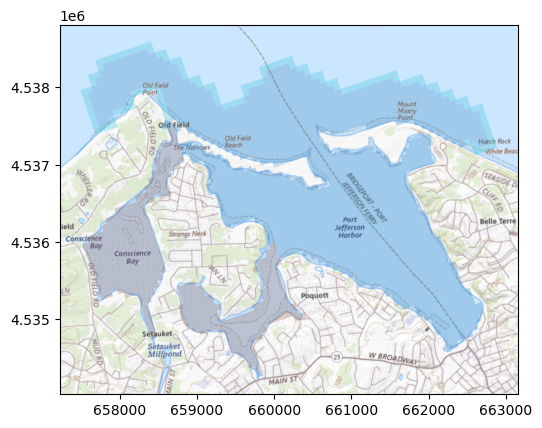

In [50]:
ax = target_coastal.plot(alpha=0.25, column="boundname")
cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

## Create the D-FLOW FM to CHD mapping

In [53]:
# generate the weights
weight_gen = WeightGenP2P(
    target_poly=target_coastal,
    target_poly_idx="chd_no",
    source_poly=source_gdf,
    source_poly_idx=["cell"],
    method="serial",
    weight_gen_crs=32618,
)
weights = weight_gen.calculate_weights()


Using serial engine
Reprojecting to epsg:EPSG:32618 finished in 0.0 second(s)
Validating polygons
     - validating source polygons
     - fixing 0 invalid polygons.
     - validating target polygons
     - fixing 0 invalid polygons.
Validate polygons finished in 0.0131 seconds
Intersections finished in 0.0301 seconds
Weight gen finished in 0.0437 seconds


In [54]:
weight_gen

In [55]:
weights[:12]
# len(weights)

,chd_no,cell,wght
0,0.0,5920,1.0
1,1.0,5920,1.0
2,2.0,5920,1.0
3,3.0,5920,1.0
4,4.0,5920,1.0
5,5.0,5920,1.0
6,6.0,5920,1.0
7,7.0,5920,1.0
8,8.0,5920,1.0
9,9.0,5920,1.0


In [56]:
map_shape = (target_coastal.shape[0], source_gdf.shape[0])
map_shape

(1816, 8323)

In [57]:
dflow2mfchd = np.zeros(map_shape, dtype=float)
print(f"{dflow2mfchd.shape}\n{dflow2mfchd}")

(1816, 8323)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [58]:
for r,c,v in zip(weights["chd_no"], weights["cell"], weights["wght"]):
    print(r,c,v)
    dflow2mfchd[int(float(r)),int(c)] = v

0.0 5920 0.9999999999999999
1.0 5920 1.0
2.0 5920 1.0
3.0 5920 1.0
4.0 5920 0.9999999999999999
5.0 5920 1.0000000000000002
6.0 5920 1.0
7.0 5920 1.0
8.0 5920 0.9999999999999999
9.0 5920 1.0
10.0 5920 1.0
11.0 5920 1.0
12.0 5920 1.0
13.0 5920 1.0
14.0 5920 1.0
15.0 5920 1.0
16.0 5979 0.06342886455168577
16.0 5920 0.936571135445501
17.0 5920 1.0
18.0 5979 1.0
19.0 5979 1.0
20.0 5920 1.0000000000000002
21.0 5920 1.0
22.0 5979 1.0
23.0 5920 0.9728855012299042
23.0 5862 0.027114498767669862
24.0 5979 1.0
25.0 5920 0.4125833812569921
25.0 5862 0.5874166187480119
26.0 5979 1.0000000000000002
27.0 5920 1.0
28.0 5920 1.0000000000000002
29.0 5920 1.0000000000000002
30.0 5920 1.0000000000000002
31.0 5920 0.0005522915740710223
31.0 5862 0.9994477084229645
32.0 5979 1.0
33.0 5920 1.0000000000000002
34.0 5920 0.9999999999999999
35.0 5862 1.0
36.0 5862 1.0
37.0 5979 1.0
38.0 5979 1.0
39.0 5979 0.7304493722045661
39.0 5920 0.2695506277958759
40.0 5979 0.0016689263186899313
40.0 5920 0.9983310736819057

## Create the chd masking array

Where the sums of the weights along a row are not equal to ~1.0

In [59]:
mask_idx = np.isclose(dflow2mfchd.sum(axis=1), 1.0)
print(f"{mask_idx.sum()}\n{mask_idx.shape}\n{mask_idx}")

1429
(1816,)
[ True  True  True ... False False False]


### Test the D-FLOW FM to CHD mapping

In [60]:
s = np.full(source_gdf.shape[0], 1.0)
h = np.full(mask_idx.shape, 2.0)
h[mask_idx] = dflow2mfchd.dot(s)[mask_idx]
s.shape, dflow2mfchd.shape, h.shape

((8323,), (1816, 8323), (1816,))

In [61]:
print(f"{h.sum()}\n{h}")

2202.999999999983
[1. 1. 1. ... 2. 2. 2.]


#### Test with a nan

In [62]:
s = np.random.random(source_gdf.shape[0])
s[1544] = -1e30
print(s)

[0.37233333 0.84427429 0.25502185 ... 0.61587203 0.80377047 0.49670342]


In [63]:
h = np.full(mask_idx.shape, 2.0)
h = dflow2mfchd.dot(s)
h.shape

(1816,)

In [64]:
print(f"{h.sum()}\n{h}")

745.313388443142
[0.38866546 0.38866546 0.38866546 ... 0.         0.         0.        ]


## Create the CHD to Qext mapping

In [65]:
chd2qext = np.transpose(dflow2mfchd.copy())

### Test the CHD to Qext mapping

In [66]:
q = np.full(chd2qext.shape[1], 1.0)

In [67]:
qext = chd2qext.dot(q)

In [68]:
print(f"{qext.sum()}\n{qext.shape}")

1438.0387035704387
(8323,)


## Save the mapping arrays

In [69]:
mf_grid_name = 'PJmf6'
fpath = f"../mapping/PJ/dflow_{grid_name}_to_{mf_grid_name}_chd.npz"
np.savez_compressed(fpath, dflow2mfchd=dflow2mfchd, chdmask=mask_idx, chd2qext=chd2qext)

In [70]:
fpath

'../mapping/PJ/dflow_LIS_modflow_bathy2_net_to_PJmf6_chd.npz'